# Imports and Helper Function

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import statsmodels.api as sm
from IPython.display import Math, display
from pymc_marketing.prior import Prior

from skpro.regression.bayesian import BayesianLinearRegressor

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def style_df(df, vmax=None, subset=None, cmap="coolwarm", hide_index=False):
    """
    Helper function - apply styling to a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to style.
    vmax : float, optional
        The maximum numeric value for the color spectrum.
        Defaults to the max value in the DataFrame.
    subset : list, optional
        List of columns to which the gradient coloring/formatting is to be applied.
    cmap : str, optional
        The color map to apply for the gradient. Defaults to 'coolwarm'.
    hide_index : bool, optional
        If True, hide the DataFrame index in the output. Defaults to False.

    Returns
    -------
    pd.io.formats.style.Styler
        The styled DataFrame.
    """
    # Determine the max value for the gradient if not provided
    if vmax is None:
        vmax = df.select_dtypes(include=["number"]).max().max()

    # If no subset provided, apply to all float columns by default
    if subset is None:
        subset = pd.IndexSlice[:, df.select_dtypes(include=["float64"]).columns]

    # Apply background gradient to numeric columns and format to 3 decimal points
    styled_df = df.style.background_gradient(
        cmap=cmap, axis=None, vmin=-vmax, vmax=vmax, subset=subset
    ).format("{:.3f}", subset=subset)

    # Handle boolean columns with specific coloring (pink for False, lightblue for True)
    bool_columns = df.select_dtypes(include=["bool"]).columns

    def color_boolean(val):
        color = "lightblue" if val else "pink"
        return f"background-color: {color}"

    # Apply the boolean-specific styling if any boolean columns exist
    if not bool_columns.empty:
        styled_df = styled_df.applymap(color_boolean, subset=bool_columns)

    # Hide the index if hide_index is True
    if hide_index:
        styled_df = styled_df.hide(axis="index")

    return styled_df

# Introduction

This notebook demonstrates how to use `skpro`'s `BayesianLinearRegressor`, which performs Bayesian linear regression powered by `PyMC` as the backend. The model defaults to weakly informative priors for both the intercept and slope, providing a flexible framework for capturing uncertainty in parameter estimates.

In addition to showcasing the `BayesianLinearRegressor`, this notebook also revisits key aspects of the Bayesian workflow, its underlying theory and its comparison with the traditional Ordinary Least Squares (OLS) regression. 

Note: this notebook requires Python >= 3.10 to run.

## Problem Statement

In this exercise, we aim to compare the performance of OLS and Bayesian Linear Regression by training both models on the same synthetic dataset and analyzing their results.

We will see that compared to OLS regression, Bayesian Linear Regression offers several key advantages:

1. **Incorporation of Prior Knowledge**: Bayesian regression allows you to incorporate prior beliefs about parameters, which can improve estimates, especially in cases where data is sparse.

2. **Uncertainty Quantification**: It provides full posterior distributions for model parameters, enabling an intuitive assessment of uncertainty in predictions.

## Synthetic Data Generation

We will first create synthetic data with just two features (`feature1` and `feature2`) and 20 data points. The true relationship between the data $\mathbf{x}$ and the target variable ($y_{\text{true}}$) is given by the equation:

\begin{equation}
y_{\text{true}} = \text{intercept}_{\text{true}} + \mathbf{x} \cdot \mathbf{m}_{\text{true}}
\end{equation}


where $\text{intercept}_{\text{true}} = 1$ and $\mathbf{m}_{\text{true}} = [2, 3]$.

The observed target values ($y_{\text{train}}$) are generated by adding Gaussian noise to the true target values:

\begin{equation}
y = y_{\text{true}} + \mathcal{N}(0, \sigma_{\text{true}})
\end{equation}
Here, $\sigma_{\text{true}} = 0.5$.


In [4]:
N = 20
np.random.seed(42)

# Creating 10 random data points containing 2 features
feature1 = np.random.uniform(0, 1, N)
feature2 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1, "feature2": feature2})

# Set the relationship between the features and the target variable
TRUE_INTERCEPT = 1
TRUE_SLOPES = np.array([2, 3])
TRUE_SIGMA = 0.5

# Calculating the true target variable
y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)

y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

# Combine the features and targets into a single DataFrame
train_data = pd.concat(
    [X_train, pd.Series(y_true, name="y_true"), pd.Series(y_train, name="y_train")],
    axis=1,
)
train_data = train_data.sort_values(by="feature1")
train_data = train_data.reset_index(drop=True)

# Display the train_data DataFrame
style_df(train_data.head())

,feature1,feature2,y_true,y_train
0,0.021,0.608,2.864,2.806
1,0.058,0.200,1.715,1.051
2,0.156,0.785,3.668,2.688
3,0.156,0.456,2.680,2.785
4,0.182,0.966,4.261,4.030


The line chart below plots the relationship between `feature1` and the targets - both the theoretical `y_true`, represented by the red line, and the observed `y_train`, represented by the blue dots.

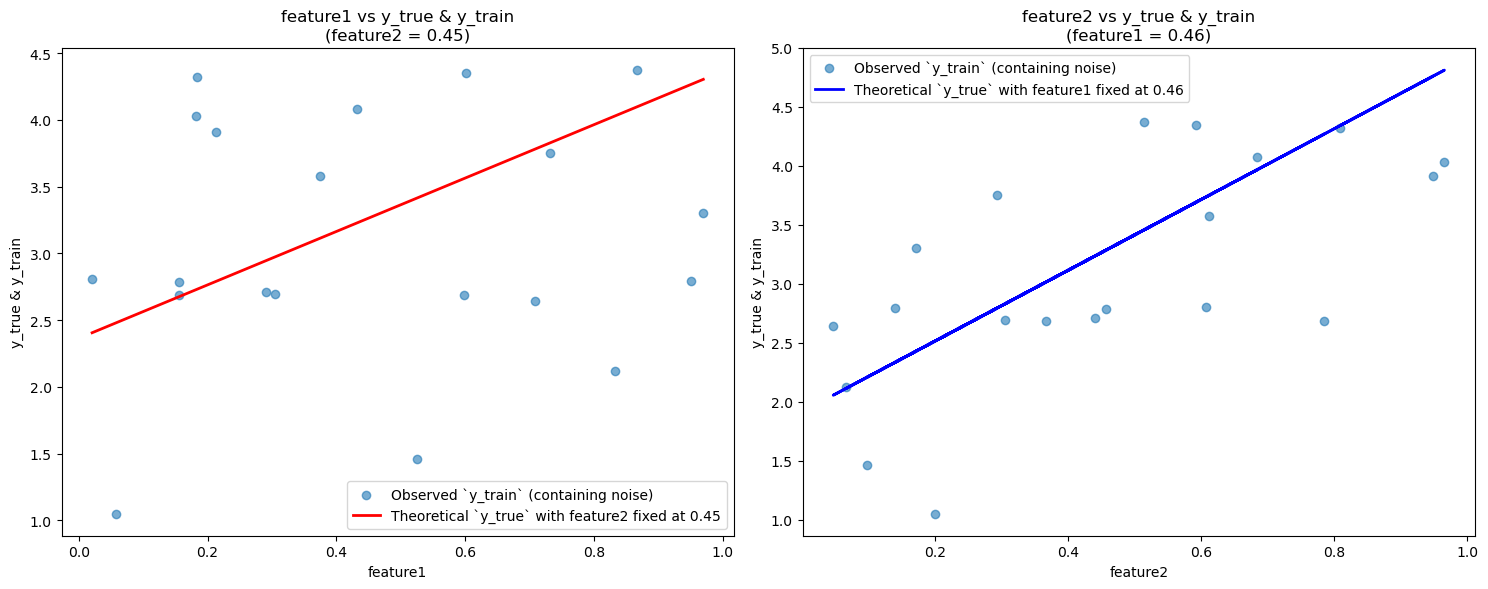

In [5]:
# Fix feature1 and feature2 constants
feature1_constant = train_data["feature1"].mean()
feature2_constant = train_data["feature2"].mean()

# Recalculate the true target `y_true` for a constant feature1
y_true_fixed_feature1 = (
    TRUE_INTERCEPT
    + TRUE_SLOPES[0] * feature1_constant
    + TRUE_SLOPES[1] * train_data["feature2"]
)

# Recalculate the true target `y_true` for a constant feature2
y_true_fixed_feature2 = (
    TRUE_INTERCEPT
    + TRUE_SLOPES[0] * train_data["feature1"]
    + TRUE_SLOPES[1] * feature2_constant
)

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot feature1 vs. y_train with feature2 constant
axes[0].scatter(
    train_data["feature1"],
    train_data["y_train"],
    label="Observed `y_train` (containing noise)",
    alpha=0.6,
)
axes[0].plot(
    train_data["feature1"],
    y_true_fixed_feature2,
    color="red",
    label=f"Theoretical `y_true` with feature2 fixed at {feature2_constant:.2f}",
    linewidth=2,
)
axes[0].set_xlabel("feature1")
axes[0].set_ylabel("y_true & y_train")
axes[0].set_title(f"feature1 vs y_true & y_train\n(feature2 = {feature2_constant:.2f})")
axes[0].legend()

# Plot feature2 vs. y_train with feature1 constant
axes[1].scatter(
    train_data["feature2"],
    train_data["y_train"],
    label="Observed `y_train` (containing noise)",
    alpha=0.6,
)
axes[1].plot(
    train_data["feature2"],
    y_true_fixed_feature1,
    color="blue",
    label=f"Theoretical `y_true` with feature1 fixed at {feature1_constant:.2f}",
    linewidth=2,
)
axes[1].set_xlabel("feature2")
axes[1].set_ylabel("y_true & y_train")
axes[1].set_title(f"feature2 vs y_true & y_train\n(feature1 = {feature1_constant:.2f})")
axes[1].legend()

# Improve spacing and show plot
plt.tight_layout()
plt.show()

We will also create synthetic **testing** data to evaluate the models' performance. The following code generates 10 new testing data points.

In [6]:
# Generate new data points for prediction with 2 features
N_test = 10
X_test = pd.DataFrame(
    {
        "feature1": np.random.uniform(0, 1, N_test),
        "feature2": np.random.uniform(0, 1, N_test),
    }
)

# Display the first few rows of X_test
style_df(X_test.head())

,feature1,feature2
0,0.075,0.358
1,0.987,0.116
2,0.772,0.863
3,0.199,0.623
4,0.006,0.331


# OLS

OLS is a method for estimating the linear relationship between independent variables (features) and a dependent variable (target).  The goal is to find a linear relationship by minimizing the sum of squared differences between the observed and predicted target values:

$$
\hat{\beta} = \arg\min_{\beta} \sum_{i=1}^n (y_i - \mathbf{x}_i^T \beta)^2
$$

We’ll use the **`statsmodels`** library to train the OLS model. This will serve as a baseline for comparison with Bayesian Linear Regression.

In [7]:
# Fit a linear regression model using statsmodels
X_train_with_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_with_const).fit()

When fitted to the data, the `ols_model` uses maximum likelihood estimation (MLE) to find the best estimates for the model parameters. A limitation of this approach is that it only provides point estimates—specific values for the slope and intercept—without any indication of the uncertainty or distribution of these estimates.

The code below demonstrates how to extract these estimates from the `ols_model`. We see that the estimated slopes, intercept, and standard deviation are somewhat close to the true values we set during data generation.

In [8]:
# Predicted values for y_train
y_train_pred = ols_model.predict(X_train_with_const)
residuals = y_train_pred - y_train


# True model
true_model_latex = rf"""
\text{{True data generating model:}} \\
y_{{\text{{true}}}} = {TRUE_SLOPES[0]:.2f} \cdot x_1 +
{TRUE_SLOPES[1]:.2f} \cdot x_2 + {TRUE_INTERCEPT:.2f} \\
\text{{True standard deviation: }} \sigma = {TRUE_SIGMA:.2f}\\
"""

# Estimated model
estimated_model_latex = rf"""
\text{{Estimated MLE model:}} \\
\hat{{y}} = {ols_model.params.iloc[1]:.2f} \cdot x_1 +
{ols_model.params.iloc[2]:.2f} \cdot x_2 + {ols_model.params.iloc[0]:.2f} \\
\text{{Standard deviation of residuals: }} \hat{{\sigma}} = {residuals.std():.2f}
"""

# Displaying the results using LaTeX
display(Math(true_model_latex))
display(Math(estimated_model_latex))

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Using the trained `ols_model`,  we can also create point predictions on the unseen `X_test` along with the corresponding confidence interval.

The latter provides a range within which we expect the true parameter to lie with a certain level of confidence (e.g., 95%).

In this code, we fix **`feature2`** at its mean value to isolate and visualize the influence of **`feature1`** on the target variable. 



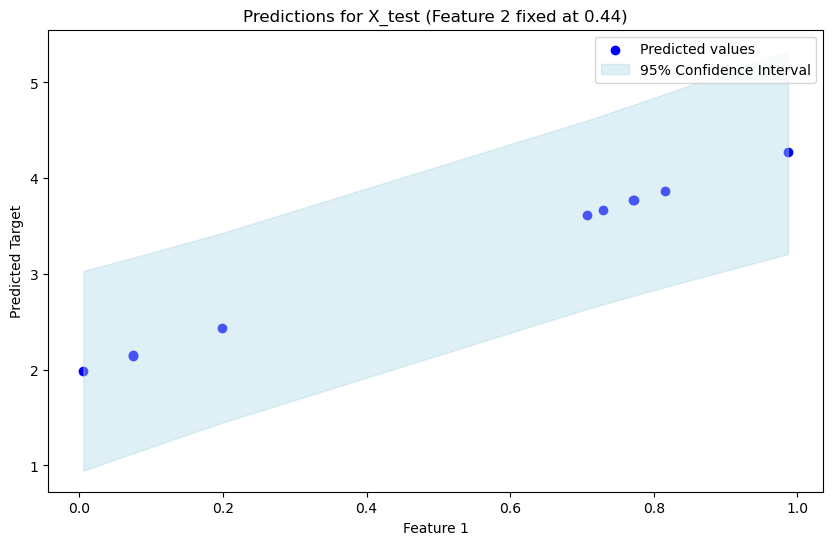

In [9]:
# Fix feature2 at its mean
feature2_constant = X_test["feature2"].mean()

# Create a new test dataset with feature2 fixed at the constant value
X_test_fixed_feature2 = X_test.copy()
X_test_fixed_feature2["feature2"] = feature2_constant

# Predict y_test using the linear model after adding constant
predictions_fixed_feature2 = ols_model.get_prediction(
    sm.add_constant(X_test_fixed_feature2, has_constant="add")
)
pred_summary_fixed_feature2 = predictions_fixed_feature2.summary_frame(alpha=0.05)

# Extract predicted values and confidence intervals
y_test_pred_fixed_feature2 = pred_summary_fixed_feature2["mean"]
conf_int_lower_fixed_feature2 = pred_summary_fixed_feature2["obs_ci_lower"]
conf_int_upper_fixed_feature2 = pred_summary_fixed_feature2["obs_ci_upper"]

sorted_indices = np.argsort(X_test["feature1"])
X_test_sorted = X_test["feature1"].iloc[sorted_indices]
y_test_pred_sorted = y_test_pred_fixed_feature2.iloc[sorted_indices]
conf_int_lower_sorted = conf_int_lower_fixed_feature2.iloc[sorted_indices]
conf_int_upper_sorted = conf_int_upper_fixed_feature2.iloc[sorted_indices]

# Plot the predictions with the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted, y_test_pred_sorted, color="blue", label="Predicted values")
plt.fill_between(
    X_test_sorted,
    conf_int_lower_sorted,
    conf_int_upper_sorted,
    color="lightblue",
    alpha=0.4,
    label="95% Confidence Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title(f"Predictions for X_test (Feature 2 fixed at {feature2_constant:.2f})")
plt.legend()
plt.show()

# Bayesian Inference

Now let's switch our attention to bayesian linear regression. Bayesian linear regression estimates the relationship between variables by incorporating prior knowledge or beliefs along with the observed data. Instead of providing single point estimates for the model parameters (like the slope and intercept), it calculates their probability distributions.

## Introduction

In this section, we will explore the theoretical framework used in Bayesian linear regression.

Bayesian linear regression directly applies Bayes' Theorem to estimate the posterior distributions of the model parameters. As a reminder, here is the Bayes Theorem:

\begin{align*}
P(\theta \mid D) &= \frac{P(D \mid \theta) \times P(\theta)}{P(D)} \\
\text{posterior} &= \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}
\end{align*}


Where:

- $\theta$ represents the model parameters, which in our case consist of the intercept $\beta_{0}$, the slopes $\beta$ and the noise $\sigma$
- $D$ represents the observed training data, which consist of $\mathbf{X}_{\text{train}}$ and  $\mathbf{y}_{\text{train}}$
- $P(\theta \mid D)$ is the posterior distribution of the parameters - given the data.
- $P(D \mid \theta)$ is the likelihood of the data given the parameters.
- $P(\theta)$ is the prior distribution of the parameters.
- $P(D)$ is the marginal likelihood (evidence), a normalizing constant ensuring the posterior is a valid probability distribution.



## `BayesianLinearRegressor`

`skpro` provides an implementation of Bayesian linear regression through the `BayesianLinearRegressor` class. Here, we create an instance of the `BayesianLinearRegressor` and fit it to our training data.

In [10]:
# data conversion and renaming to facilitate downstream analysis
y_train = pd.DataFrame(y_train)
y_train.columns = ["target"]

In [11]:
%timeit
bayes_model = BayesianLinearRegressor()
bayes_model.fit(X_train, y_train)

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!
instantiated BayesianLinearRegressor with the following priors:
  - intercept: Prior("Normal", mu=0, sigma=100)
  - slopes: Prior("Normal", mu=0, sigma=100, dims="pred_id")
  - noise_var: Prior("HalfCauchy", beta=5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=0, sigma=100),
                                      'noise_var': Prior("HalfCauchy", beta=5),
                                      'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

## Prior

### Default Prior

The prior $P(\theta)$ reflects our beliefs about the parameters before observing any data. In Bayesian inference, the choice of prior can significantly impact the results, especially when the amount of data is limited.

In the case of **`BayesianLinearRegression`**, the model includes a default prior that is **weakly informative**. A weakly informative prior is designed to provide some structure without being overly restrictive or introducing strong assumptions. 

You can inspect these default priors by accessing the `default_prior_config` attribute of the model instance. This attribute will show the priors assigned to parameters like the intercept, slopes, and noise variance. 

In [12]:
bayes_model.default_prior_config

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!


{'intercept': Prior("Normal", mu=0, sigma=100),
 'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id"),
 'noise_var': Prior("HalfCauchy", beta=5)}

We see that they are as follows:

\begin{align*}
\text{intercept} &== \beta_{0} &\sim \mathcal{N}(0, 100) \\
\text{slopes} &== \beta &\sim \mathcal{N}(0, 100) \\
\text{noise} &== \sigma &\sim \text{HalfCauchy}(\beta=5)
\end{align*}


We can sample from these prior distributions using the `sample_prior` method of the `bayes_model`, specifying `numpy` arrays as the output format. The samples can then be plotted for visualization.

Sampling: [intercept, noise_var, slopes, y_obs]


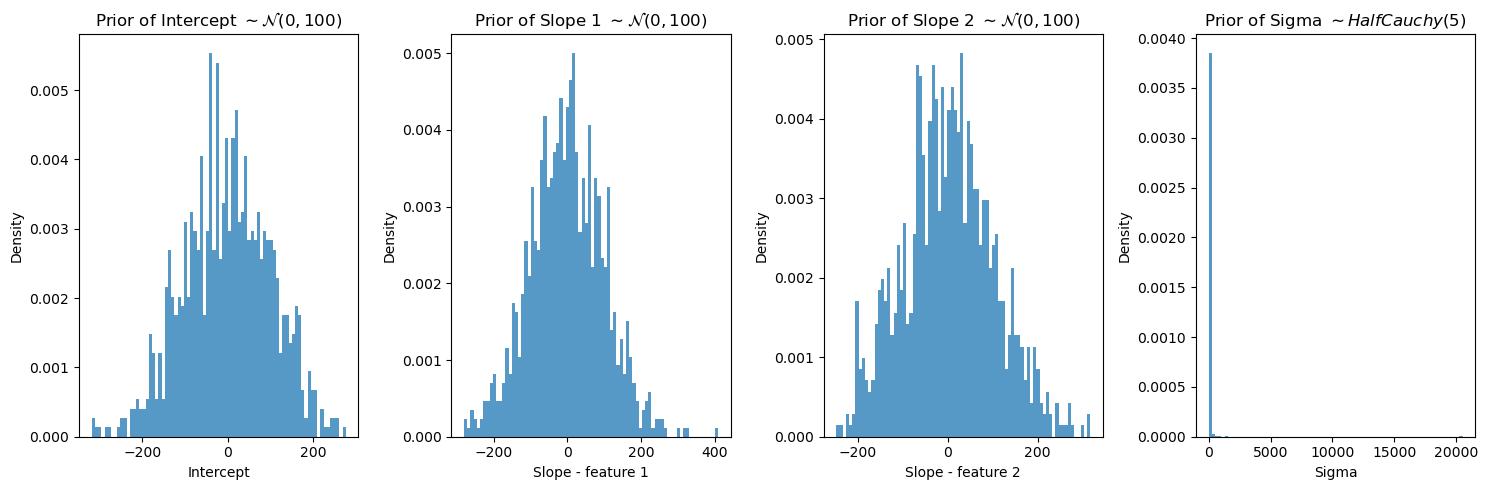

In [13]:
# get the prior samples as a dictionary of numpy arrays
prior_samples = bayes_model.sample_prior("numpy")

# Plot the prior distributions
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot prior for intercept
axes[0].hist(prior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].set_title(r"Prior of Intercept $\sim \mathcal{N}(0, 100)$")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")


# Plot prior for slopes
axes[1].hist(prior_samples["slopes_feature1"], bins=80, density=True, alpha=0.75)
axes[1].set_title(r"Prior of Slope 1 $\sim \mathcal{N}(0, 100)$")
axes[1].set_xlabel("Slope - feature 1")
axes[1].set_ylabel("Density")

axes[2].hist(prior_samples["slopes_feature2"], bins=80, density=True, alpha=0.75)
axes[2].set_title(r"Prior of Slope 2 $\sim \mathcal{N}(0, 100)$")
axes[2].set_xlabel("Slope - feature 2")
axes[2].set_ylabel("Density")


# Plot prior for sigma
axes[3].hist(prior_samples["noise_var"], bins=80, density=True, alpha=0.75)
axes[3].set_title(r"Prior of Sigma $\sim HalfCauchy(5)$")
axes[3].set_xlabel("Sigma")
axes[3].set_ylabel("Density")

plt.tight_layout()
plt.show()

Note that the method `sample_prior` that we use above can return us the samples in different data types. If we wish to, we could also ask for our priors an `skpro` distribution. 

Another convenient method is `get_prior_summary()` which calculates a summary statistics of our priors.

In [14]:
bayes_model.get_prior_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.942,101.544,-186.723,177.891,3.257,2.304,974.0,975.0,NaN
slopes[feature1],-1.225,99.838,-203.817,173.313,3.252,2.344,941.0,875.0,NaN
slopes[feature2],2.958,100.046,-203.620,170.676,3.352,2.371,890.0,996.0,NaN
noise_var,39.432,653.651,0.014,45.035,20.613,14.591,1005.0,848.0,NaN
noise,3.170,5.423,0.201,6.714,0.170,0.121,1005.0,848.0,NaN


### Prior Elicitation

The default priors may not align with our beliefs, so we need to define priors that do. This process, known as **prior elicitation**, involves crafting priors that reflect domain knowledge. 


We'll use **PreliZ**, a library in the PyMC/ArviZ ecosystem, to assist with this. `PreliZ` simplifies prior elicitation by offering tools to define priors that balance domain expertise with minimal bias. While its full capabilities are beyond this tutorial’s scope, we'll demonstrate how to use it to define a prior for the intercept in a Bayesian linear regression model. 


`PreliZ` uses maximum entropy methods to incorporate real-world knowledge—like plausible baseline ranges—into the model, ensuring we choose a minimally biased prior within reasonable constraints.

For example, if our domain knowledge suggests the intercept is likely close to 1, we can use `pz.maxent` to define a Normal prior where 60% of the probability mass lies within [0.8, 1.2].  We can also visually inspect this prior.

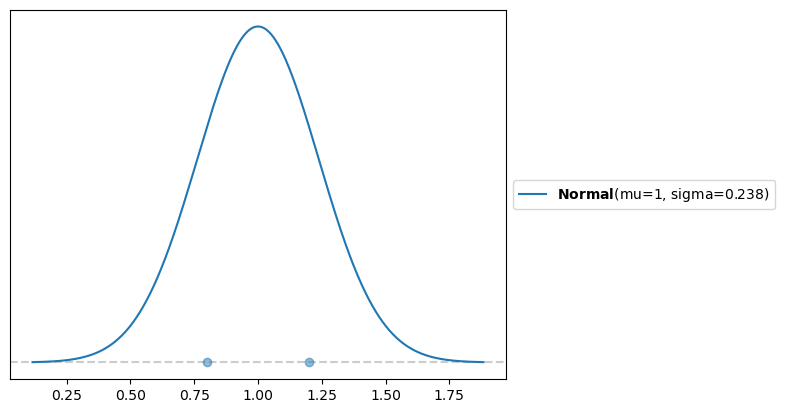

In [15]:
elicited_prior_pz, _ = pz.maxent(pz.Normal(), 0.8, 1.2, 0.6);

Once defined, the elicited prior can be seamlessly converted into the `Prior` class from `PyMC` - a data type required for the prior configuration of `BayesLinearRegressor` model. 

We can then instantiate a new `BayesLinearRegressor` model using this elicited prior. 
Note that the other priors remain at their default values. 

In [16]:
elicited_prior = Prior("Normal", mu=elicited_prior_pz.mu, sigma=elicited_prior_pz.sigma)

bayes_model = BayesianLinearRegressor(prior_config={"intercept": elicited_prior})
bayes_model.fit(X_train, y_train)

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!
instantiated BayesianLinearRegressor with the following priors:
  - intercept: Prior("Normal", mu=1.0000659133714382, sigma=0.23763668100677832)
  - slopes: Prior("Normal", mu=0, sigma=100, dims="pred_id")
  - noise_var: Prior("HalfCauchy", beta=5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=1.0000659133714382, sigma=0.23763668100677832),
                                      'noise_var': Prior("HalfCauchy", beta=5),
                                      'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

## Likelihood



The likelihood function $P(D \mid \theta)$ represents how likely it is to observe the given data, $D$, given a set of parameters $\theta$.

For linear regression, we are assume that each observed data point $y_i$ is normally distributed around its predicted value $\beta_0 + X_i \beta$, with variance $\sigma^2$.
    
$$P(D \mid \beta, \sigma) = \prod_{i=1}^{n} \mathcal{N}(y_i \mid \beta_0 + X_i \beta, \sigma^2)$$

where:

- $y_i$ are the observed target values,
- $X_i$ are the observed feature values,
- $\beta_0$ is the intercept,
- $\beta$ are the slopes/regression coefficients for the features,
- $\sigma$ is the standard deviation of the errors.


## Posterior

The posterior distribution, denoted as $P(\theta \mid D)$, represents the updated beliefs about the parameters $\theta$ after observing the data $D$. PyMC obtains the posterior distribution using Markov Chain Monte Carlo (MCMC) algorithms, which iteratively explore the parameter space, generating a sequence of samples that approximate the posterior distribution.

We can extract the posterior using the `sample_posterior` method of the `bayes_model`. 

In [17]:
posterior_samples = bayes_model.sample_posterior("numpy")

By plotting the posterior distributions, we observe two key points:
- The posterior distributions are much narrower than the initial priors, showing that the data has significantly refined our estimates.
- The posterior means, also known as Bayesian estimates, are closer to the true values than the MLE estimates from OLS. This improvement is due to the well-specified informative prior for the intercept

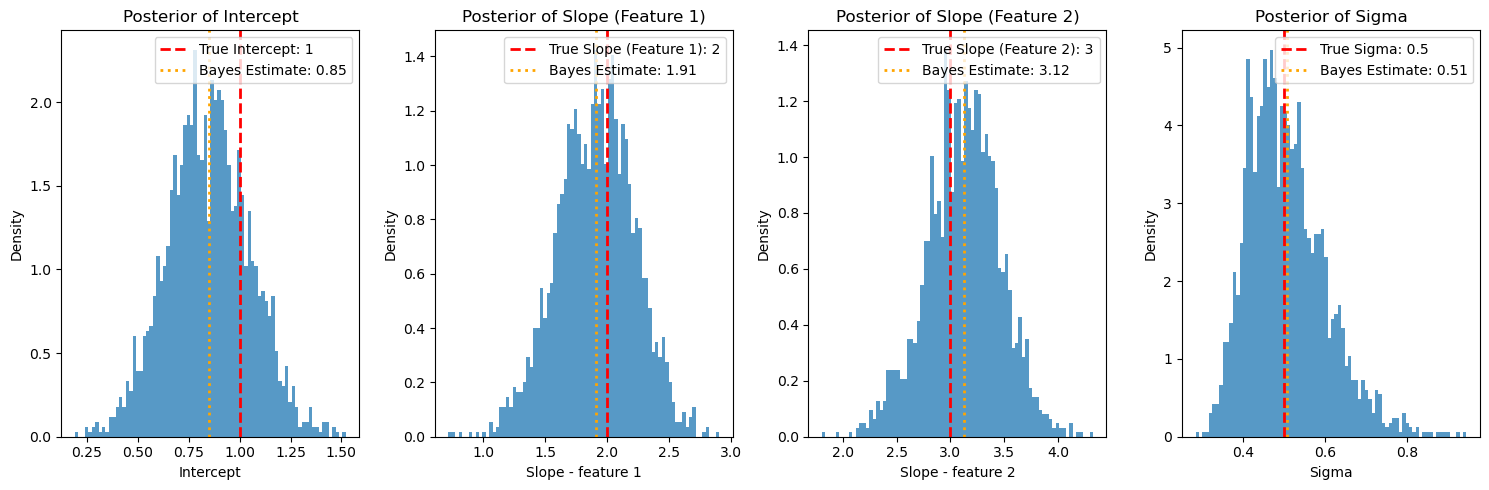

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Same figsize as the prior plot

# Calculate Bayesian estimates (mean of posterior)
bayes_estimate_intercept = posterior_samples["intercept"].mean()
bayes_estimate_slope1 = posterior_samples["slopes_feature1"].mean()
bayes_estimate_slope2 = posterior_samples["slopes_feature2"].mean()
bayes_estimate_sigma = posterior_samples["noise"].mean()

# Plot posterior for intercept
axes[0].hist(posterior_samples["intercept"], bins=80, density=True, alpha=0.75)
axes[0].axvline(
    TRUE_INTERCEPT,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Intercept: {TRUE_INTERCEPT}",
)
axes[0].axvline(
    bayes_estimate_intercept,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_intercept:.2f}",
)
axes[0].set_title("Posterior of Intercept")
axes[0].set_xlabel("Intercept")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plot posterior for slope feature 1
axes[1].hist(posterior_samples["slopes_feature1"], bins=80, density=True, alpha=0.75)
axes[1].axvline(
    TRUE_SLOPES[0],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Slope (Feature 1): {TRUE_SLOPES[0]}",
)
axes[1].axvline(
    bayes_estimate_slope1,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_slope1:.2f}",
)
axes[1].set_title("Posterior of Slope (Feature 1)")
axes[1].set_xlabel("Slope - feature 1")
axes[1].set_ylabel("Density")
axes[1].legend()

# Plot posterior for slope feature 2
axes[2].hist(posterior_samples["slopes_feature2"], bins=80, density=True, alpha=0.75)
axes[2].axvline(
    TRUE_SLOPES[1],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Slope (Feature 2): {TRUE_SLOPES[1]}",
)
axes[2].axvline(
    bayes_estimate_slope2,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_slope2:.2f}",
)
axes[2].set_title("Posterior of Slope (Feature 2)")
axes[2].set_xlabel("Slope - feature 2")
axes[2].set_ylabel("Density")
axes[2].legend()

# Plot posterior for sigma (noise)
axes[3].hist(posterior_samples["noise"], bins=80, density=True, alpha=0.75)
axes[3].axvline(
    TRUE_SIGMA,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"True Sigma: {TRUE_SIGMA}",
)
axes[3].axvline(
    bayes_estimate_sigma,
    color="orange",
    linestyle=":",
    linewidth=2,
    label=f"Bayes Estimate: {bayes_estimate_sigma:.2f}",
)
axes[3].set_title("Posterior of Sigma")
axes[3].set_xlabel("Sigma")
axes[3].set_ylabel("Density")
axes[3].legend()

plt.tight_layout()
plt.show()

We can make use of `get_posterior_summary()` to print out the summary statistics of our posterior.
Note the low values of the standard deviation - indicating the 'spikiness' of our distributions!

In [19]:
bayes_model.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.847,0.203,0.475,1.230,0.006,0.005,1005.0,1053.0,1.0
slopes[feature1],1.908,0.311,1.341,2.492,0.009,0.006,1265.0,1445.0,1.0
slopes[feature2],3.121,0.340,2.414,3.709,0.010,0.007,1099.0,831.0,1.0
noise_var,0.266,0.105,0.103,0.446,0.003,0.003,997.0,1015.0,1.0
noise,0.507,0.095,0.343,0.682,0.003,0.002,997.0,1015.0,1.0


Additionally, note that apart from using the convenience functions provided by the BayesianLinearRegressor, such as `get_posterior_summary`, you can directly access the `idata` attribute of the model instance. This 'idata' object is a container for all inference data we've used on this model so far, including the training data, the prior and the posterior. 

Once you have the `idata` object, you can use the `arviz` library to analyze and visualize any distributions created during the model's lifetime, such as the prior and posterior distributions. `arviz` provides a rich set of tools for diagnostics, plotting, and summarizing the results of Bayesian models. This allows for a thorough examination of the model's behavior and the reliability of the inferred parameters.

For example, here, we use `arviz`'s `plot_posterior` to plot the posterior distribution of the `intercept ` variable.

<Axes: title={'center': 'intercept'}>

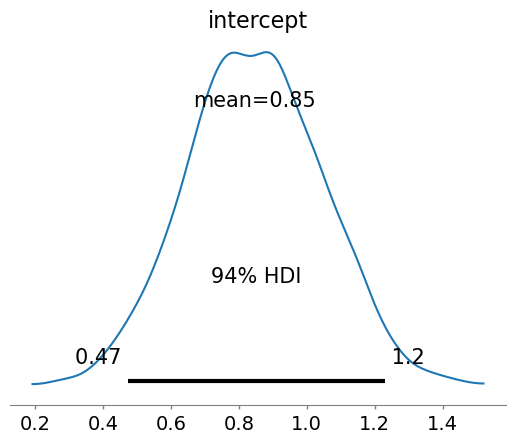

In [20]:
az.plot_posterior(bayes_model.idata, var_names="intercept")

# Model checking



Before using our Bayesian model to make predictions, it is advisable to perform some sanity checks to ascertain the correctness of the model set up and the assumptions. This section describes some of the most commonly used checks.

## `graphviz` Visualization

One way to understand the `bayes_model` is to visualize its composition using the `.visualize_model` method. This method uses the `graphviz` library to generate a graphical representation of the model, illustrating the relationships and dependencies between the priors, likelihood, data and the posterior.


The graphviz diagram will show the following:

- Ovals indicate stochastic nodes (random variables).
- Rectangles represent deterministic nodes (computed values).
- Shaded shapes (like the shaded ovals for X and y) indicate observed data or fixed inputs.
- Unshaded shapes represent latent variables or parameters that the model is trying to infer.

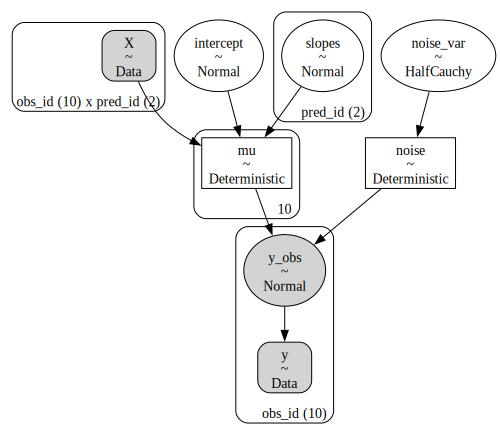

In [36]:
bayes_model.visualize_model()

## Posterior Predictive Check


A posterior predictive check (PPC), in general, is a method used to assess the fit of a Bayesian model by comparing observed data to data simulated from the model. It helps to identify discrepancies between the model predictions and the observed data, thereby providing a way to evaluate the adequacy of the model.

In our specific case, we'll use PPC to compare our target variable `y_train` versus the in-sample predictions (thin of it as `y_train_pred` generated by our model).

The `BayesianLinearRegressor` class provides a convenient method, `plot_ppc` to visually perform PPC.

The resulting plot will show the following components:

1. **Blue Lines**: represent the posterior predictive samples, which are the range of possible values that the model predicts for the observed data, given the posterior distribution of the parameters.

2. **Black Line**: represents the density of the observed data values (i.e. our `y_train`)

3. **Orange Dashed Line**: represents the mean of the posterior predictive distribution, whichprovides a central tendency of the model's predictions.

The plot is used to visually assess the goodness of fit of the Bayesian model. By comparing the observed data distribution (black line) to the mean of posterior predictive samples (orange dashed line), we can see if there are significant discrepancies. 

We can see below that the observed data closely follows the central tendency and falls within the range of the posterior predictive samples, suggesting a decent fit. 

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

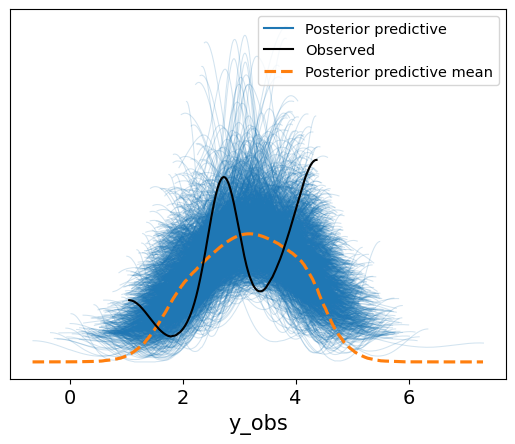

In [22]:
bayes_model.plot_ppc()

# Making Predictions

Now, it's time to use the trained `bayes_model` to perform out-of-sample prediction. As mentioned earlier, a significant benefit of using the Bayesian model is that it generates a full distribution for each test data point, rather than a single point estimate. This provides a more comprehensive understanding of the uncertainty and variability in the predictions.

In our class, this is accomplished using the `predict_proba` method, which returns an `skpro` `Empirical` distribution.


## `predict_proba`

In [23]:
y_pred_proba_bayes = bayes_model.predict_proba(X_test)

Sampling: [y_obs]


Output()

The returned distribution is known as the **posterior predictive distribution**. This distribution provides probabilistic forecasts for future observations by incorporating uncertainty about the model parameters and data variability.

The posterior predictive distribution enables us to make probabilistic statements about future observations and understand the variability in our predictions.



The posterior predictive distribution is given by:

$$
p(y_{\text{pred}} \mid X_{\text{new}}, X_{\text{train}}, y_{\text{train}}) = \int p(y_{\text{pred}} \mid X_{\text{new}}, \theta) p(\theta \mid X_{\text{train}}, y_{\text{train}}) \, d\theta
$$

where:
- $y_{\text{pred}}$ is the new predicted data point.
- $X_{\text{new}}$ is the new input.
- $\mathbf{X}_{\text{train}}$ is the set of observed inputs.
- $\mathbf{y}_{\text{train}}$ is the set of observed outputs.
- $\mathbf{\theta}$ represents the model parameters.
- $p(y_{\text{pred}} | X_{\text{new}}, \mathbf{\theta})$ is the likelihood of the new data point given the model parameters.
- $p(\mathbf{\theta} | \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$ is the posterior distribution of the model parameters given the observed data.

The above equation states that to obtain the distribution of the predictions $y_{\text{pred}}$, we need to perform two iterative sampling:

1. First, we sample from the posterior distribution $p(\theta \mid X_{\text{train}}, y_{\text{train}})$

2. Afterwards, for each sampled $\theta$ from the posterior, we sample $y_{\text{pred}}$ from the predictive distribution $p(y_{\text{pred}} \mid X_{\text{new}}, \theta)$.

In practice, PyMC conveniently handles this sequential sampling process for us.

## `predict`

If point predictions are what we're after, we've got the `predict` method to do so. Internally, this `predict` method calls the `predict_proba` method above and averages the resulting posterior predictive distribution to provide a single point estimate for each test data point.

In [24]:
y_pred_bayes = bayes_model.predict(X_test)
y_pred_bayes.head()

Sampling: [y_obs]


Output()

,target
obs_id,
0,2.103758
1,3.072778
2,5.020030
3,3.176504
4,1.872894


## `predict_quantiles`

The advantage of obtaining a full predictive distribution for our test set is that we can quantify our uncertainty by calculating quantiles. This can be conveniently achieved using the `predict_quantiles` method. Here, we use `predict_quantiles` to get the 25-th and 75-th percentiles of the posterior predictive distributions.

We'll then use these quantiles to plot our predictions together with their uncertainty.


In [25]:
y_pred_bayes_quantiles = bayes_model.predict_quantiles(X_test, [0.25, 0.75])
y_pred_bayes_quantiles.head()

Sampling: [y_obs]


Output()

target          
            0.25      0.75
obs_id                    
0       1.771690  2.467104
1       2.729244  3.474662
2       4.627393  5.380591
3       2.825824  3.528885
4       1.517310  2.216297

## `predict_interval`

Lastly, the model comes with the `predict_interval` method. This method returns the **credible interval**, which is a range within which a certain proportion of the posterior distribution lies. For example, a 95% credible interval for a parameter $\theta$ means that there is a 95% probability that $\theta$ lies within this interval, given the observed data and the prior distribution.

In [26]:
y_pred_bayes_interval = bayes_model.predict_interval(X_test, 0.95)
y_pred_bayes_interval.head()

Sampling: [y_obs]


Output()

target          
            0.95          
           lower     upper
obs_id                    
0       1.136406  3.177711
1       1.969842  4.215953
2       3.869512  6.104017
3       2.146375  4.217355
4       0.887110  2.945063

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

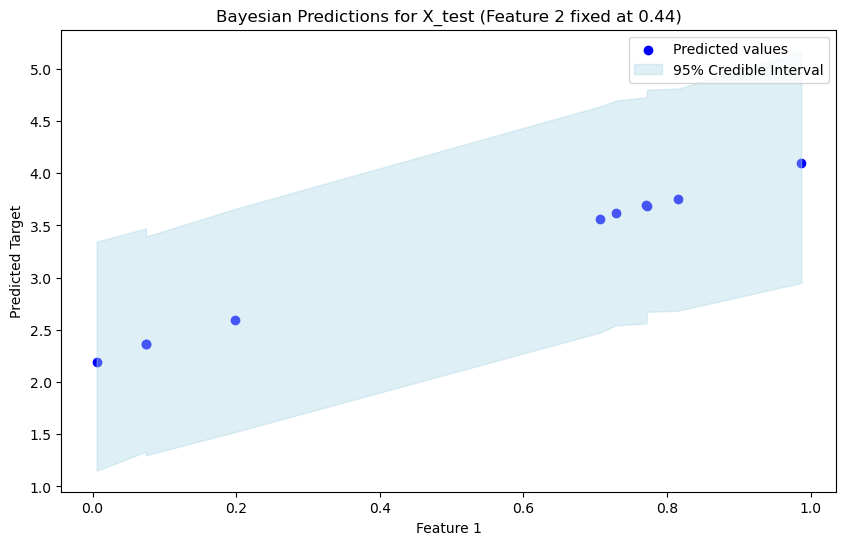

In [27]:
# Fix feature2 at its mean
feature2_constant = X_test["feature2"].mean()

# Create a new test dataset with feature2 fixed at the constant value
X_test_fixed_feature2 = X_test.copy()
X_test_fixed_feature2["feature2"] = feature2_constant


# Get predictions and credible intervals from the Bayesian model
# Assuming predict_interval gives both the mean predictions and the intervals at 95% CI
y_pred_bayes_interval_fixed_feature2 = bayes_model.predict_interval(
    X_test_fixed_feature2, 0.95
)
y_pred_bayes_fixed_feature2 = bayes_model.predict(X_test_fixed_feature2)


# Extract mean, lower, and upper credible intervals
credible_lower_fixed_feature2 = y_pred_bayes_interval_fixed_feature2["target"][0.95][
    "lower"
]
credible_upper_fixed_feature2 = y_pred_bayes_interval_fixed_feature2["target"][0.95][
    "upper"
]

# Sort X_test by 'feature1'
sorted_indices = np.argsort(X_test_fixed_feature2["feature1"])
X_test_sorted = X_test_fixed_feature2["feature1"].iloc[sorted_indices]
y_pred_bayes_sorted = y_pred_bayes_fixed_feature2.iloc[sorted_indices]
credible_lower_sorted = credible_lower_fixed_feature2.iloc[sorted_indices]
credible_upper_sorted = credible_upper_fixed_feature2.iloc[sorted_indices]

# Plot the predictions with the credible intervals
plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted, y_pred_bayes_sorted, color="blue", label="Predicted values")
plt.fill_between(
    X_test_sorted,
    credible_lower_sorted,
    credible_upper_sorted,
    color="lightblue",
    alpha=0.4,
    label="95% Credible Interval",
)
plt.xlabel("Feature 1")
plt.ylabel("Predicted Target")
plt.title(
    f"Bayesian Predictions for X_test (Feature 2 fixed at {feature2_constant:.2f})"
)
plt.legend()
plt.show()

# Effect of Sample Size

Lastly, let's take a look at how the size of training sample affects the width of the posteriors and posterior predictive distributions.

## Posterior

Let's remind ourselves as to how our posterior distribution look like after we've trained our model with 20 training data points.

In [28]:
bayes_model.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.847,0.203,0.475,1.230,0.006,0.005,1005.0,1053.0,1.0
slopes[feature1],1.908,0.311,1.341,2.492,0.009,0.006,1265.0,1445.0,1.0
slopes[feature2],3.121,0.340,2.414,3.709,0.010,0.007,1099.0,831.0,1.0
noise_var,0.266,0.105,0.103,0.446,0.003,0.003,997.0,1015.0,1.0
noise,0.507,0.095,0.343,0.682,0.003,0.002,997.0,1015.0,1.0


How does this posterior change when we train a model with more data points?

Now, let's generate a synthetic dataset with 200 datapoints and use it to train another model.

In [29]:
N = 200
np.random.seed(42)
feature1 = np.random.uniform(0, 1, N)
feature2 = np.random.uniform(0, 1, N)
X_train = pd.DataFrame({"feature1": feature1, "feature2": feature2})


y_true = TRUE_INTERCEPT + np.dot(X_train, TRUE_SLOPES)
y_train = y_true + np.random.normal(0, TRUE_SIGMA, size=len(X_train))

train_data = pd.concat(
    [X_train, pd.Series(y_true, name="y_true"), pd.Series(y_train, name="y_train")],
    axis=1,
)
train_data = train_data.sort_values(by="feature1")
train_data = train_data.reset_index(drop=True)

bayes_model_200 = BayesianLinearRegressor(prior_config={"intercept": elicited_prior})
bayes_model_200.fit(X_train, y_train)

The model assumes that the intercept and slopes are independent. 
            Modify the model if this assumption doesn't apply!
instantiated BayesianLinearRegressor with the following priors:
  - intercept: Prior("Normal", mu=1.0000659133714382, sigma=0.23763668100677832)
  - slopes: Prior("Normal", mu=0, sigma=100, dims="pred_id")
  - noise_var: Prior("HalfCauchy", beta=5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes, noise_var]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BayesianLinearRegressor(prior_config={'intercept': Prior("Normal", mu=1.0000659133714382, sigma=0.23763668100677832),
                                      'noise_var': Prior("HalfCauchy", beta=5),
                                      'slopes': Prior("Normal", mu=0, sigma=100, dims="pred_id")},
                        sampler_config={'chains': 2, 'draws': 1000,
                                        'progressbar': True, 'random_seed': 123,
                                        'target_accept': 0.95, 'tune': 1000})

We see that with this 10x increase in training set size, we obtain narrower posteriors, as evidenced by the lower `sd` values in the summary. It is noteworthy that the reduction of the standard deviation, which is around 3x, is less than the 10x reduction one might expect.

In [30]:
bayes_model_200.get_posterior_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.036,0.089,0.866,1.199,0.002,0.002,1277.0,1106.0,1.0
slopes[feature1],2.006,0.116,1.792,2.215,0.003,0.002,1506.0,1332.0,1.0
slopes[feature2],2.917,0.118,2.697,3.127,0.003,0.002,1367.0,1186.0,1.0
noise_var,0.250,0.024,0.207,0.297,0.001,0.000,1405.0,1318.0,1.0
noise,0.499,0.024,0.456,0.546,0.001,0.000,1405.0,1318.0,1.0


In [31]:
sd_ratio = (
    bayes_model.get_posterior_summary() / bayes_model_200.get_posterior_summary()
)["sd"]
sd_ratio.name = "ratio of std dev when 10x training data is used"
sd_ratio

intercept           2.280899
slopes[feature1]    2.681034
slopes[feature2]    2.881356
noise_var           4.375000
noise               3.958333
Name: ratio of std dev when 10x training data is used, dtype: float64

## Posterior Predictive

Now, let's perform the same experiment, this time comparing the posterior predictive distribution coming from the two models.

In order to get the posterior predictive distribution from the second model (`bayes_model_500`), we first need to use it to perform prediction on the test set.

In [32]:
y_pred_proba_bayes_200 = bayes_model_200.predict_proba(X_test)

Sampling: [y_obs]


Output()

With that out of the way, let's now compare the posterior predictive distributions for both models.

In [33]:
az.summary(bayes_model.idata.predictions)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],2.360,0.534,1.303,3.356,0.012,0.009,1924.0,1749.0,1.0
y_obs[1],4.095,0.562,3.049,5.126,0.013,0.009,1898.0,1721.0,1.0
y_obs[2],3.682,0.539,2.702,4.716,0.012,0.008,2056.0,2008.0,1.0
y_obs[3],2.590,0.518,1.608,3.508,0.012,0.008,1990.0,1726.0,1.0
y_obs[4],2.197,0.524,1.257,3.258,0.012,0.009,1889.0,1846.0,1.0
y_obs[5],3.752,0.554,2.669,4.756,0.013,0.009,1849.0,1850.0,1.0
y_obs[6],3.566,0.557,2.569,4.646,0.013,0.009,1773.0,1794.0,1.0
y_obs[7],3.617,0.534,2.610,4.636,0.012,0.009,1861.0,1847.0,1.0
y_obs[8],3.692,0.543,2.548,4.678,0.012,0.009,1989.0,1782.0,1.0
y_obs[9],2.360,0.524,1.347,3.309,0.012,0.009,1743.0,1787.0,1.0


In [34]:
az.summary(bayes_model_200.idata.predictions)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],2.239,0.498,1.291,3.129,0.011,0.008,1944.0,1834.0,1.0
y_obs[1],3.353,0.507,2.392,4.295,0.012,0.008,1890.0,1829.0,1.0
y_obs[2],5.096,0.516,4.117,6.032,0.012,0.009,1802.0,1887.0,1.0
y_obs[3],3.269,0.510,2.298,4.213,0.012,0.008,1910.0,1892.0,1.0
y_obs[4],2.025,0.507,1.079,3.001,0.011,0.008,2223.0,1909.0,1.0
y_obs[5],2.864,0.510,1.877,3.797,0.012,0.008,1967.0,1979.0,1.0
y_obs[6],3.371,0.513,2.373,4.292,0.011,0.008,2072.0,1852.0,1.0
y_obs[7],3.459,0.501,2.468,4.348,0.012,0.008,1808.0,1894.0,1.0
y_obs[8],4.713,0.505,3.704,5.598,0.012,0.009,1725.0,1810.0,1.0
y_obs[9],3.047,0.496,2.075,3.931,0.011,0.008,2106.0,1810.0,1.0


We see that there is practically no difference in the standard deviation of the posterior predictive of both models.

In [35]:
(
    az.summary(bayes_model_200.idata.predictions)
    / az.summary(bayes_model.idata.predictions)
)[["sd"]]

,sd
y_obs[0],0.932584
y_obs[1],0.902135
y_obs[2],0.957328
y_obs[3],0.984556
y_obs[4],0.967557
y_obs[5],0.920578
y_obs[6],0.921005
y_obs[7],0.938202
y_obs[8],0.930018
y_obs[9],0.946565


# References



- [How to use the posterior predictive distribution for checking a model in PyMC](https://discourse.pymc.io/t/how-to-use-the-posterior-predictive-distribution-for-checking-a-model-from-pymc/11593/9) - A discussion on how to leverage posterior predictive checks in PyMC.
  
- [PyMC documentation: `sample_prior_predictive`](https://www.pymc.io/projects/docs/en/v5.15.1/api/generated/pymc.sample_prior_predictive.html) - Official PyMC documentation for generating samples from the prior predictive distribution.

- [Bishop - Pattern Recognition and Machine Learning (2006)](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) - A comprehensive reference on machine learning theory and Bayesian methods by Christopher M. Bishop.

- [Updating priors](https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html)